In [ ]:
!pip install numpy pandas scikit-learn scipy setfit firebase-admin imbalanced-learn shap pymorphy2 nltk seaborn matplotlib

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
  import inspect

# Патч
if not hasattr(inspect, 'getargspec'):
    def getargspec(func):
        from collections import namedtuple
        ArgSpec = namedtuple('ArgSpec', 'args varargs keywords defaults')
        fullargspec = inspect.getfullargspec(func)
        return ArgSpec(
            args=fullargspec.args,
            varargs=fullargspec.varargs,
            keywords=fullargspec.varkw,
            defaults=fullargspec.defaults
        )
    inspect.getargspec = getargspec

In [ ]:
!pip install wandb --upgrade

In [ ]:
pip install -U setfit wandb sentence-transformers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.sparse import hstack, csr_matrix
from setfit import SetFitModel, Trainer
from firebase_admin import firestore, credentials, initialize_app
import firebase_admin
from shap import Explainer, plots
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss, confusion_matrix
import nltk
from pymorphy2 import MorphAnalyzer
import re
import seaborn as sns
import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
from datasets import Dataset

# Инициализация
nltk.download('punkt')
morph = MorphAnalyzer()

# Константы
RUSSIAN_STOP_WORDS = {'и', 'в', 'во', 'на', 'с', 'со', 'так', 'к', 'у', 'же', 'за', 'по', 'от', 'о', 'из', 'ну', 'до', 'уж', 'для', 'без', 'под', 'ж'}

# Функция лемматизации
def lemmatize_text(text):
    words = re.findall(r'\w+', text.lower())
    return [morph.parse(word)[0].normal_form for word in words if word not in RUSSIAN_STOP_WORDS]

def load_data():
    if not firebase_admin._apps:
      cred = credentials.Certificate("serviceAccountKey(2).json")
      firebase_admin.initialize_app(cred, {
          'databaseURL': 'https://nlp-coursework-try3-default-rtdb.europe-west1.firebasedatabase.app'
    })

    # Используем его для доступа к базе
    ref = db.reference('interview_data_try2')
    data = ref.get()
    display(len(data))

    texts, labels = [], []

    # Проверяем, что данные существует
    if data:
        for key, value in data.items():
            # Проверяем, что запись содержит нужные поля и текст >= 3 слов
            if 'text' in value and 'label' in value and len(value['text'].split()) >= 3:
                texts.append(value['text'])
                labels.append(value['label'])

    return texts, labels


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1. Загрузка данных...


416


2. Разделение данных...
Train: 327 samples | Test: 82 samples

3. Инициализация компонентов...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/327 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 74820
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.286000
50,0.367700
100,0.289200
150,0.242400
200,0.235800
250,0.226000
300,0.220100
350,0.206100
400,0.201400
450,0.183200



5. Генерация признаков...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



6. Балансировка классов...

7. Обучение RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 50}

8. Оценка модели...

Метрики на тестовых данных:
Accuracy: 0.8537
F1 (weighted): 0.8581
Log Loss: 0.7274

Classification Report:
              precision    recall  f1-score   support

 Нейтральный       0.30      0.75      0.43         4
     Процесс       0.95      0.94      0.95        67
   Результат       0.67      0.36      0.47        11

    accuracy                           0.85        82
   macro avg       0.64      0.68      0.62        82
weighted avg       0.88      0.85      0.86        82



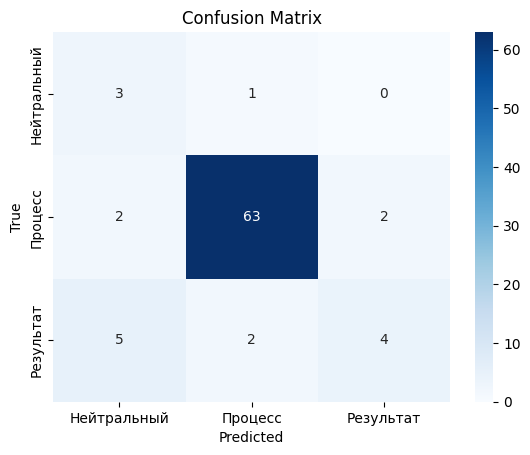

In [ ]:
    # 1. Загрузка данных
    print("1. Загрузка данных...")
    texts, labels = load_data()

    # 2. Разделение данных
    print("\n2. Разделение данных...")
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )
    print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")

    # 3. Инициализация моделей
    print("\n3. Инициализация компонентов...")
    # TF-IDF
    tfidf = TfidfVectorizer(
        tokenizer=lemmatize_text,
        max_features=1000,
        ngram_range=(1, 2),
        stop_words=list(RUSSIAN_STOP_WORDS)
    )

    # SetFit модель
    setfit_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L3-v2")

    # 4. Обучение SetFit (1 эпоха для few-shot)
    train_dataset = Dataset.from_dict({
        "text": X_train,
        "label": y_train
    })

    trainer = Trainer(
        model=setfit_model,
        train_dataset=train_dataset,
    )
    trainer.train()


    # 5. Генерация признаков
    print("\n5. Генерация признаков...")
    # TF-IDF
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # BERT-эмбеддинги
    X_train_bert = setfit_model.encode(X_train)
    X_test_bert = setfit_model.encode(X_test)

    # Масштабирование
    scaler = StandardScaler()
    X_train_bert_scaled = scaler.fit_transform(X_train_bert)
    X_test_bert_scaled = scaler.transform(X_test_bert)

    # Объединение признаков
    X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_bert_scaled)])
    X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_bert_scaled)])

    # 6. Балансировка классов
    print("\n6. Балансировка классов...")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_combined, y_train)

    # 7. Обучение RandomForest
    print("\n7. Обучение RandomForest...")
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [3, 5],
        'class_weight': ['balanced']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=5,
        n_jobs=-1,
        scoring='f1_weighted',
        verbose=1
    )
    grid_search.fit(X_train_res, y_train_res)

    best_rf = grid_search.best_estimator_
    print(f"\nЛучшие параметры: {grid_search.best_params_}")

    # 8. Оценка
    print("\n8. Оценка модели...")
    y_pred = best_rf.predict(X_test_combined)
    y_proba = best_rf.predict_proba(X_test_combined)

    # Метрики
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 (weighted)": f1_score(y_test, y_pred, average='weighted'),
        "Log Loss": log_loss(y_test, y_proba)
    }

    print("\nМетрики на тестовых данных:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # Отчет классификации
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=best_rf.classes_,
                yticklabels=best_rf.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()




In [ ]:
    import shap

    # 9. SHAP объяснения
    print("\n9. Генерация SHAP объяснений...")
    class CombinedModel:
        def __init__(self, tfidf, setfit_model, rf_model):
            self.tfidf = tfidf
            self.setfit_model = setfit_model
            self.rf_model = rf_model

        def predict_proba(self, texts):
            if isinstance(texts, np.ndarray):
                X_tfidf = texts[:, :1000]
                X_emb = texts[:, 1000:]
                return self.rf_model.predict_proba(np.hstack([X_tfidf, X_emb]))

            return self.rf_model.predict_proba(
                np.hstack([
                    self.tfidf.transform(texts),
                    self.setfit_model.encode(texts)
                ])
            )

    # 2. Инициализация
    combined_model = CombinedModel(tfidf, setfit_model, best_rf)

    dummy_combined = np.zeros((1, 1000 + 384))  # TF-IDF + SetFit размерности

    # 4. Инициализация explainer
    explainer = Explainer(
        combined_model.predict_proba,
        masker=dummy_combined,
        output_names=best_rf.classes_,
        max_evals=2*(1000+384) + 2  # = 2770
    )

    # 5. Пример использования
    sample_indices = np.random.choice(len(X_test), size=min(3, len(X_test)), replace=False)
    for idx in sample_indices:
        print(f"\nТекст: {X_test[idx]}")
        print(f"Истинный класс: {y_test[idx]}")
        print(f"Предсказанный класс: {y_pred[idx]}")

        text_processed = [X_test[idx]]
        X_transformed = np.hstack([
            tfidf.transform(text_processed).toarray(),
            setfit_model.encode(text_processed)
        ])

        # Вычисление SHAP значений

        # 1. Создаем список слов из текста
        text = X_test[idx]
        words = text.split()

        shap_values = explainer(X_transformed)

        # 2. Создаем маппинг фичей к словам
        num_word_features = min(len(words), 1000)
        feature_names = words[:num_word_features] + [f"emb_{i}" for i in range(384)]

        # 3. Создаем правильный объект Explanation
        shap_text_values = shap.Explanation(
            values=shap_values.values[0, :num_word_features+384, 1],
            base_values=shap_values.base_values[0, 1],
            data=words[:num_word_features] + [""]*384,
            feature_names=feature_names
        )

        # 4. Настраиваем визуализацию
        shap.plots.text(
            shap_text_values
        )

    # 10. Кросс-валидация на всех данных
    print("\n10. Кросс-валидация на всех данных...")
    X_full = hstack([tfidf.transform(texts), csr_matrix(setfit_model.encode(texts))])
    cv_scores = cross_val_score(
        best_rf,
        X_full,
        labels,
        cv=5,
        scoring='f1_weighted'
    )
    print(f"F1 (weighted) кросс-валидация: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")


9. Генерация SHAP объяснений...

Текст: Дмитрий Козлов, основатель сети «Кофе с характером» (5 заведений в Москве)
Истинный класс: Нейтральный
Предсказанный класс: Нейтральный



Текст: Травматичный вопрос! Мы проводим ежеквартальный аудит: проверяем, чтобы ИИ не дискриминировал по полу, возрасту или образованию. Например, выяснилось, что одна модель переоценивала кандидатов из небольших городов — пришлось переобучать на расширенной выборке. Непрозрачность — ключевой принцип.
Истинный класс: Результат
Предсказанный класс: Нейтральный



Текст: Пример какой-то привести?
Истинный класс: Результат
Предсказанный класс: Нейтральный



10. Кросс-валидация на всех данных...
F1 (weighted) кросс-валидация: 0.98 ± 0.01


In [ ]:
from joblib import dump

dump(tfidf, 'tfidf.joblib')  # TF-IDF из sklearn
dump(best_rf, 'rf.joblib')   # Random Forest из sklearn

['rf.joblib']

In [ ]:
setfit_model.save_pretrained('model/')  # папка с моделью сентенс трансформер